All Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
import tensorflow.keras.models as models
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional, Reshape
import matplotlib.pyplot as plt
import mlflow

2024-04-19 12:32:02.821290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 12:32:03.523395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load both CSV files into pandas dataframes

In [2]:
df1 = pd.read_csv('aapl_2016_2020.csv')
df2 = pd.read_csv('aapl_2021_2023.csv')

C:\Users\benal\AppData\Local\Temp\ipykernel_20452\3057472841.py:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('aapl_2016_2020.csv')
C:\Users\benal\AppData\Local\Temp\ipykernel_20452\3057472841.py:2: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('aapl_2021_2023.csv')


Concatenate the dataframes along rows (assuming they have the same columns)

In [3]:
raw_df = pd.concat([df1, df2], ignore_index=True)

Save the merged dataframe to a new CSV file

In [4]:
raw_df.to_csv('merged.csv', index=False)

In [2]:
raw_df = pd.read_csv('merged.csv')

/tmp/ipykernel_4757/596435398.py:1: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('merged.csv')


Get rid of [ ] in the column name

In [5]:
columns = raw_df.columns
columns = [s.replace('[', '') for s in columns]
columns = [s.replace(']', '') for s in columns]
columns = [s.replace(' ', '') for s in columns]

raw_df.columns = columns

Some columns will not be handled well when converting raw numeric strings to Python's integer and float datatypes. 

Therefore, we will treat these features separately and join them again later.

In [6]:
date_columns = ['QUOTE_READTIME','QUOTE_DATE','EXPIRE_DATE','QUOTE_TIME_HOURS', 'C_SIZE', 'P_SIZE']
numeric_cols = raw_df.columns.to_list()
numeric_cols.remove('QUOTE_READTIME')
numeric_cols.remove('QUOTE_DATE')
numeric_cols.remove('EXPIRE_DATE')
numeric_cols.remove('QUOTE_TIME_HOURS')
numeric_cols.remove('C_SIZE')
numeric_cols.remove('P_SIZE')

numeric_cols

['QUOTE_UNIXTIME',
 'UNDERLYING_LAST',
 'EXPIRE_UNIX',
 'DTE',
 'C_DELTA',
 'C_GAMMA',
 'C_VEGA',
 'C_THETA',
 'C_RHO',
 'C_IV',
 'C_VOLUME',
 'C_LAST',
 'C_BID',
 'C_ASK',
 'STRIKE',
 'P_BID',
 'P_ASK',
 'P_LAST',
 'P_DELTA',
 'P_GAMMA',
 'P_VEGA',
 'P_THETA',
 'P_RHO',
 'P_IV',
 'P_VOLUME',
 'STRIKE_DISTANCE',
 'STRIKE_DISTANCE_PCT']

In [7]:
numeric_df = raw_df.drop(columns=date_columns)

for i in numeric_cols:
    numeric_df[i] = pd.to_numeric(numeric_df[i], errors='coerce')

Now we drop all rows that contains an element that is NaN

In [8]:
numeric_df = numeric_df.dropna()

Choosing our Features X and Target Y

In [9]:
X = numeric_df.drop(columns=['P_LAST', 'C_LAST'])
y = numeric_df[['P_LAST', 'C_LAST']]

Scale transform the data

In [10]:
scaler = MinMaxScaler(feature_range=(0.1, 1))
X, y = scaler.fit_transform(X), scaler.fit_transform(y)

Convert them into matrices

In [11]:
X, y = np.array(X), np.array(y)

Check Dimensions of the features and targets

In [12]:
print(X.shape, y.shape)

(872082, 25) (872082, 2)


Split data into train and test (80%:20%)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Start our MLflow run

In [14]:
mlflow.set_experiment("options_prediction1")

2024/04/18 00:03:48 INFO mlflow.tracking.fluent: Experiment with name 'options_prediction1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/benal/AI-Financial-Assistant/mlruns/310814173313511215', creation_time=1713395028546, experiment_id='310814173313511215', last_update_time=1713395028546, lifecycle_stage='active', name='options_prediction1', tags={}>

Build our model and run it with MLflow

In [17]:
with mlflow.start_run():
    model = Sequential([
        Dense(units=256, input_dim=X_train.shape[1], activation='relu'),
        Reshape((1, 256)),
        Bidirectional(SimpleRNN(units=128, activation='sigmoid', return_sequences=False)),
        Dense(units=64, activation='tanh'),
        Reshape((1, 64)),
        Bidirectional(SimpleRNN(units=32, activation='relu', return_sequences=True)),
        SimpleRNN(units=16, activation='sigmoid', return_sequences=False),
        Dense(units=2)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Log model configuration with MLflow
    mlflow.log_param("model", "Bidirectional_RNN")
    mlflow.log_param("rnn_layers", 2)
    mlflow.log_param("dense_layers", 2)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 20)
    mlflow.log_param("optimizer", "adam")

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate and log metrics
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    test_loss = model.evaluate(X_test, y_test)

    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)

    # Save the model
    model_path = "bidirectional_rnn_model.h5"
    model.save(model_path)
    mlflow.log_artifact(model_path)

    mlflow.end_run()


Epoch 1/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0013 - val_loss: 1.7801e-04
Epoch 2/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 1.8291e-04 - val_loss: 1.9213e-04
Epoch 3/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1.7431e-04 - val_loss: 2.1600e-04
Epoch 4/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 1.7077e-04 - val_loss: 1.7426e-04
Epoch 5/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1.6565e-04 - val_loss: 1.7969e-04
Epoch 6/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 1.6329e-04 - val_loss: 1.6401e-04
Epoch 7/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1.6305e-04 - val_loss: 1.4811e-04
Epoch 8/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 1.5843e-04 - val_loss: 1.5133e-04
Epoch 9/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1.5712e-04 - val_loss: 1.8192e-04
Epoch 10/20
21803/21803 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 1.5444e-04 - val_loss: 1.5054e-04
Epoch 11/20
2

Now we plot the Loss function

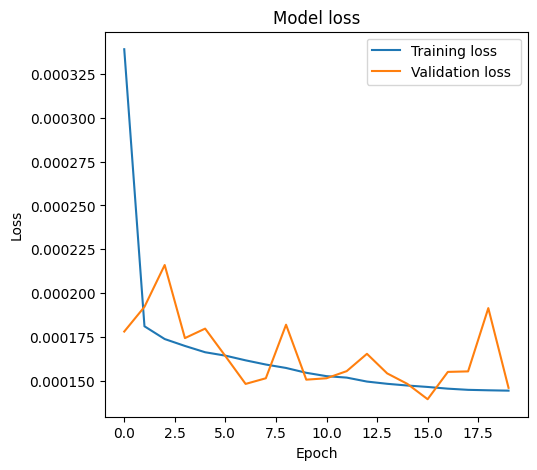

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss ')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()